In [8]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
import pandas as pd

torch.manual_seed(42)

# Linear Regression

Форма аналитического решения:
w = (XᵀX)⁻¹Xᵀy
(если X полнорангова и (XᵀX)⁻¹ существует)

Матричная регрессия нестабильна при мультиколлинеарности — признаки линейно зависимы → XᵀX почти необратима → численная нестабильность → лучше использовать np.linalg.pinv или регуляризацию.

In [ ]:
x = np.linspace(0, 1, 32)
y = np.exp(x) + 3.2

### Линейная регрессия на np

In [ ]:
class LinearRegressionNp:

    def __init__(self, n_features: int):
        self.w = np.random.normal(0, 1 / n_features ** 0.5, (n_features, 1))
        self.b = 1.
        self.n_features = n_features
    
    
    def _check_shapes(self, input_data: np.array):
        if len(input_data.shape) != 2:
            if len(input_data.shape) == 1:
                input_data = input_data.reshape((len(input_data), 1))
        
        assert len(input_data.shape) == 2
        assert input_data.shape[1] == self.n_features
        
        return input_data


    def fit(self, x: np.array, y: np.array, lr: float = 2e-3, max_steps: int = 100):
        x = self._check_shapes(x)
        assert len(x) == len(y)

        n = len(x)
        
        losses = []

        for step in range(max_steps):
            logits = x @ self.w + self.b
                    
            losses.append(np.sum((logits - y) ** 2) / n)

            # loss = np.sum((logits - y) ** 2) / n = ((logits_1 - y_1) ** 2 + ... + (logits_i - y_i) ** 2) / n
            # logits.shape = (batch_size, 1)
            # dloss/dlogits_i = 2 * (logits_i - y_i) / n
            dloss_dlogits = 2 * (logits.ravel() - y) / n

            # logits = x @ self.w + self.b
            dloss_dw = x.T @ dloss_dlogits  # Матричное дифференцирование
            
            dloss_db = np.sum(dloss_dlogits, axis=0)

            self.w -= dloss_dw * lr
            self.b -= dloss_db * lr

        return losses
    
    
    def predict(self, x: np.array):
        x = self._check_shapes(x)
        return x @ self.w + self.b

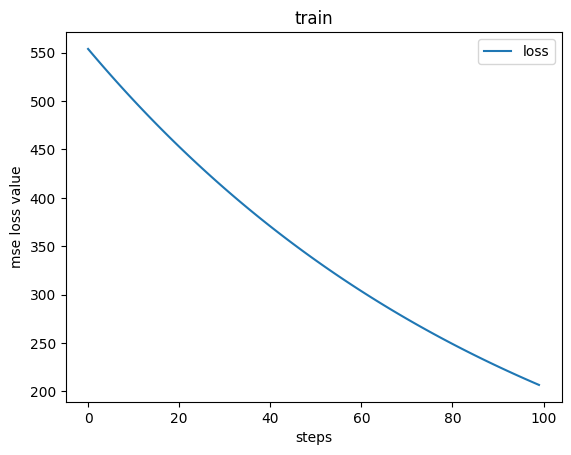

In [ ]:
linreg = LinearRegressionNp(n_features=1)
losses = linreg.fit(x, y)
plt.plot(losses, label="loss")
plt.xlabel("steps")
plt.ylabel("mse loss value")
plt.title("train")
plt.legend()
plt.show()

epoch=0 | weight=[[0.14208099]] | bias=2.0425 | mean_loss=399.6157
epoch=1 | weight=[[0.53206603]] | bias=2.7502 | mean_loss=188.9574
epoch=2 | weight=[[0.79949091]] | bias=3.2304 | mean_loss=92.5455
epoch=3 | weight=[[0.98351975]] | bias=3.5558 | mean_loss=48.6562
epoch=4 | weight=[[1.1107881]] | bias=3.7759 | mean_loss=28.8432
epoch=5 | weight=[[1.19941107]] | bias=3.9245 | mean_loss=20.0187
epoch=6 | weight=[[1.26170923]] | bias=4.0245 | mean_loss=16.1765
epoch=7 | weight=[[1.30606241]] | bias=4.0914 | mean_loss=14.5705
epoch=8 | weight=[[1.33817039]] | bias=4.1359 | mean_loss=13.9523
epoch=9 | weight=[[1.36191031]] | bias=4.1651 | mean_loss=13.7593


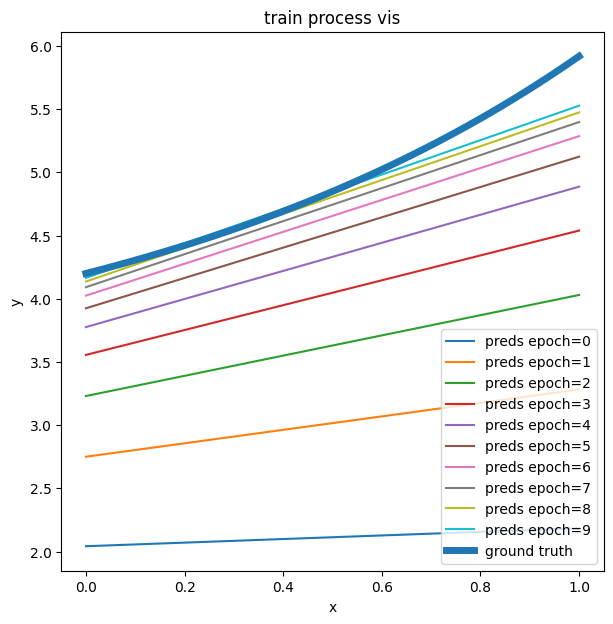

In [ ]:
linreg = LinearRegressionNp(n_features=1)

plt.figure(figsize=(7, 7))
preds = []
for epoch in range(10):
    losses = linreg.fit(x, y, max_steps=15, lr=0.01)
    plt.plot(x, linreg.predict(x), label=f"preds {epoch=}")
    print(f"{epoch=} | weight={linreg.w} | bias={linreg.b:.4f} | mean_loss={sum(losses) / len(losses):.4f}")

plt.plot(x, y, linewidth=5, label="ground truth")
plt.xlabel("x")
plt.ylabel("y")
plt.title("train process vis")
plt.legend()
plt.show()

### Линейная регрессия на torch без autograd

In [ ]:
class LinearRegressionTorch:

    def __init__(self, n_features: int, l2: float = 0.01):
        self.w = torch.randn((n_features, 1)) / n_features ** 0.5
        self.b = torch.zeros((1, ))
        self.l2 = l2
        self.n_features = n_features
    
    
    def __call__(self, x: torch.Tensor, y: torch.Tensor = None):
        logits = x @ self.w + self.b

        loss = None
        if y is not None:
            loss = torch.mean((logits - y) ** 2) + self.l2 * torch.sum(self.w ** 2)  # l2 норма весов
        
        return logits, loss
    

    def fit(self, x: torch.Tensor, y: torch.Tensor, lr: float = 2e-3, max_steps: int = 100):
        n = len(x)

        losses = []
        for step in range(max_steps):
            logits, loss  = self(x, y)
            losses.append(loss.item())

            dloss_dlogits = 2 * (logits - y) / n
            dloss_dw = x.T @ dloss_dlogits + 2 * self.l2 * self.w
            dloss_db = torch.sum(dloss_dlogits, dim=0)

            self.w -= dloss_dw * lr
            self.b -= dloss_db * lr

        return losses

epoch=0 | weight=tensor([[1.2010]]) | bias=1.6559 | mean_loss=13.9985
epoch=1 | weight=tensor([[1.6757]]) | bias=2.5855 | mean_loss=4.3960
epoch=2 | weight=tensor([[1.9329]]) | bias=3.1092 | mean_loss=1.3970
epoch=3 | weight=tensor([[2.0689]]) | bias=3.4060 | mean_loss=0.4595
epoch=4 | weight=tensor([[2.1373]]) | bias=3.5758 | mean_loss=0.1656
epoch=5 | weight=tensor([[2.1683]]) | bias=3.6746 | mean_loss=0.0727
epoch=6 | weight=tensor([[2.1786]]) | bias=3.7336 | mean_loss=0.0426
epoch=7 | weight=tensor([[2.1775]]) | bias=3.7702 | mean_loss=0.0321
epoch=8 | weight=tensor([[2.1703]]) | bias=3.7942 | mean_loss=0.0279
epoch=9 | weight=tensor([[2.1599]]) | bias=3.8111 | mean_loss=0.0257


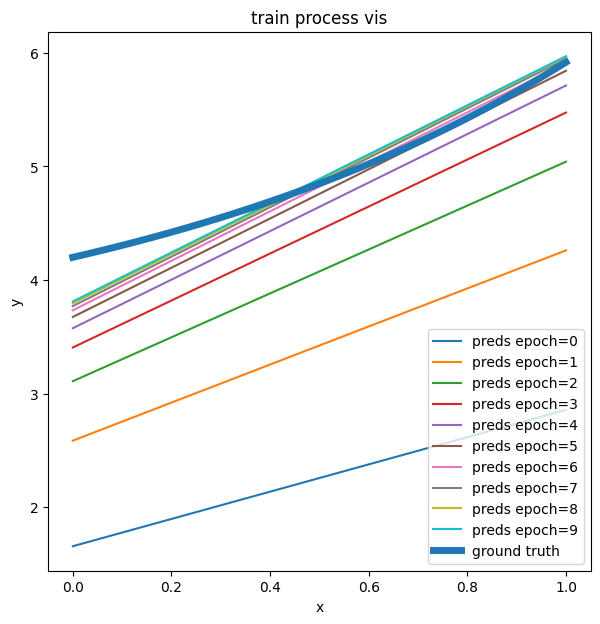

In [ ]:
plt.figure(figsize=(7, 7))

epoches = 10
epoch_steps = 15
lr = 1.5e-2

linreg = LinearRegressionTorch(n_features=1)

for epoch in range(epoches):
    losses = linreg.fit(x, y, lr=lr, max_steps=epoch_steps)
    plt.plot(x, linreg(x)[0], label=f"preds {epoch=}")
    print(f"{epoch=} | weight={linreg.w} | bias={linreg.b.item():.4f} | mean_loss={sum(losses) / len(losses):.4f}")

plt.plot(x, y, linewidth=5, label="ground truth")
plt.xlabel("x")
plt.ylabel("y")
plt.title("train process vis")
plt.legend()
plt.show()

### Линейная регрессия на torch с autograd

In [ ]:
class LinearRegressionTorchAutograd(nn.Module):

    def __init__(self, n_features: int, l2: float = 0.01):
        super().__init__()
        self.w = nn.Linear(in_features=n_features, out_features=1, bias=True)
        self.l2 = l2
    
    
    def forward(self, x: torch.Tensor, y: torch.Tensor = None):
        logits = self.w(x)

        loss = None
        if y is not None:
            loss = nn.MSELoss()(input=logits, target=y) + self.l2 * torch.sum(self.w.weight ** 2)
        
        return logits, loss

epoch=0 | weight=1.4342 | bias=2.1228 | mean_loss=8.5185
epoch=1 | weight=1.8003 | bias=2.8494 | mean_loss=2.6843
epoch=2 | weight=1.9970 | bias=3.2596 | mean_loss=0.8617
epoch=3 | weight=2.0994 | bias=3.4929 | mean_loss=0.2915
epoch=4 | weight=2.1492 | bias=3.6271 | mean_loss=0.1123
epoch=5 | weight=2.1700 | bias=3.7060 | mean_loss=0.0552
epoch=6 | weight=2.1747 | bias=3.7537 | mean_loss=0.0364
epoch=7 | weight=2.1706 | bias=3.7840 | mean_loss=0.0295
epoch=8 | weight=2.1619 | bias=3.8044 | mean_loss=0.0265
epoch=9 | weight=2.1508 | bias=3.8191 | mean_loss=0.0246


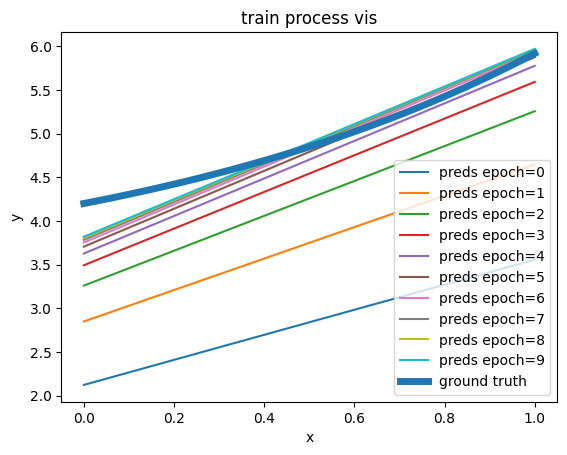

In [ ]:
epoches = 10
epoch_steps = 15
lr = 1.5e-2

linreg = LinearRegressionTorchAutograd(n_features=1)
optimizer = torch.optim.SGD(linreg.parameters(), lr=lr)

for epoch in range(epoches):
    linreg.train()
    losses = []
    for step in range(epoch_steps):
        optimizer.zero_grad()
        logits, loss = linreg(x, y)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
    
    linreg.eval()
    with torch.no_grad():
        plt.plot(x, linreg(x)[0], label=f"preds {epoch=}")
        print(f"{epoch=} | weight={linreg.w.weight.item():.4f} | bias={linreg.w.bias.item():.4f} | mean_loss={sum(losses) / len(losses):.4f}")

plt.plot(x, y, linewidth=5, label="ground truth")
plt.xlabel("x")
plt.ylabel("y")
plt.title("train process vis")
plt.legend()
plt.show()

# Binary Logistic Regression

In [151]:
from matplotlib.patches import Patch


n_samples_per_class = 100

# Класс 0: центр (-2, -2)
x0 = torch.randn(n_samples_per_class, 2) * 0.75 - 1
y0 = torch.zeros(n_samples_per_class, dtype=torch.float32)

# Класс 1: центр (+2, +2)
x1 = torch.randn(n_samples_per_class, 2) * 0.75 + 1
y1 = torch.ones(n_samples_per_class, dtype=torch.float32)

# Объединяем
idx = torch.randint(0, 200, size=(200, ))
x = torch.cat([x0, x1], dim=0)[idx]
y = torch.cat([y0, y1], dim=0).unsqueeze(1)[idx]  # (200, 1)

### Логистическая регрессия на torch без autograd

In [65]:
class LogisticRegressionTorch:

    def __init__(self, n_features: int, l2: float = 0.01):
        self.w = torch.randn((n_features, 1)) / n_features ** 0.5
        self.b = torch.zeros((1, ))
        self.l2 = l2
        self.n_features = n_features
    
    
    def __call__(self, x: torch.Tensor):
        return x @ self.w + self.b
    
    
    def predict(self, x: torch.Tensor):
        probs = torch.sigmoid(self(x))
        preds = torch.zeros_like(probs)
        preds[probs > 0.5] = 1
        
        return preds
    

    def fit(self, x: torch.Tensor, y: torch.Tensor, lr: float = 2e-3, max_steps: int = 100):
        n = len(x)

        losses = []
        for step in range(max_steps):

            # forward pass
            logits = self(x)
            exp_logits = torch.exp(-logits)
            probs = 1 / (1 + exp_logits)
            bce_loss = -torch.sum(torch.log(probs) * y + torch.log(1 - probs) * (1 - y))
            loss = bce_loss + self.l2 * torch.sum(self.w ** 2)  # l2 норма весов

            # backward pass
            dloss_dprobs = -(1 / probs * y - 1 / (1 - probs) * (1 - y))
            dloss_dw = 2 * self.l2 * self.w

            dprobs_dexp_logits = -1 / (1 + exp_logits) ** 2
            dloss_dexp_logits = dprobs_dexp_logits * dloss_dprobs

            dexp_logits_dlogits = -exp_logits
            dloss_dlogits = dexp_logits_dlogits * dloss_dexp_logits

            dlogits_dw = x.T
            dloss_dw += dlogits_dw @ dloss_dlogits

            dlogits_db = 1
            dloss_db = dlogits_db * torch.sum(dloss_dlogits, dim=0)

            self.w -= dloss_dw * lr
            self.b -= dloss_db * lr

            losses.append(loss.item())

        return losses

epoch=0 | weight=[[1.8411589860916138], [1.7680987119674683]] | bias=0.0618 | mean_loss=29.2642
epoch=1 | weight=[[2.1699085235595703], [2.275678873062134]] | bias=0.0769 | mean_loss=15.3971
epoch=2 | weight=[[2.390197992324829], [2.6065235137939453]] | bias=0.0825 | mean_loss=12.6622
epoch=3 | weight=[[2.560560464859009], [2.8547632694244385]] | bias=0.0845 | mean_loss=11.3137
epoch=4 | weight=[[2.7012925148010254], [3.0539443492889404]] | bias=0.0851 | mean_loss=10.4896
epoch=5 | weight=[[2.822075128555298], [3.2202460765838623]] | bias=0.0853 | mean_loss=9.9283
epoch=6 | weight=[[2.9283549785614014], [3.362820863723755]] | bias=0.0853 | mean_loss=9.5195
epoch=7 | weight=[[3.023530960083008], [3.487395763397217]] | bias=0.0855 | mean_loss=9.2081
epoch=8 | weight=[[3.109879493713379], [3.5978121757507324]] | bias=0.0858 | mean_loss=8.9627
epoch=9 | weight=[[3.189009189605713], [3.6967833042144775]] | bias=0.0864 | mean_loss=8.7645


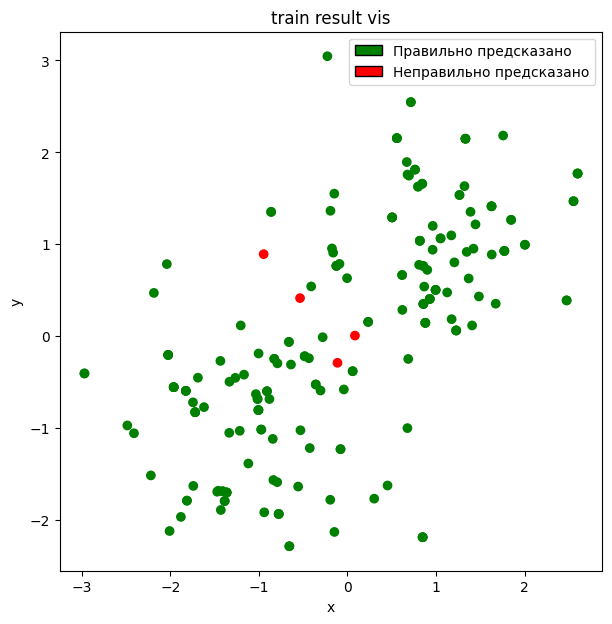

In [ ]:
# Обучение
epoches = 10
epoch_steps = 15
lr = 6e-3

logreg = LogisticRegressionTorch(n_features=2)

for epoch in range(epoches):
    losses = logreg.fit(x, y, lr=lr, max_steps=epoch_steps)
    print(f"{epoch=} | weight={logreg.w.tolist()} | bias={logreg.b.item():.4f} | mean_loss={sum(losses) / len(losses):.4f}")

# Визуализация
plt.figure(figsize=(7, 7))
preds = logreg.predict(x).numpy()
colors = np.array(["r"] * len(preds))
colors[y.numpy().squeeze() == preds.squeeze()] = "g"
plt.scatter(x[:, 0], x[:, 1], c=colors)

legend_elements = [
    Patch(facecolor="green", edgecolor="black", label="Правильно предсказано"),
    Patch(facecolor="red", edgecolor="black", label="Неправильно предсказано")
]

plt.xlabel("x")
plt.ylabel("y")
plt.title("train result vis")
plt.legend(handles=legend_elements)
plt.show()

### Логистическая регрессия на torch с autograd

In [126]:
class LogisticRegressionTorchAutograd(nn.Module):

    def __init__(self, n_features: int, l2: float = 0.01):
        super().__init__()

        self.w = nn.Linear(in_features=n_features, out_features=1, bias=True)
        self.l2 = l2
    
    
    def forward(self, x: torch.Tensor, y: torch.Tensor = None):
        logits = self.w(x)
        probs = torch.sigmoid(logits)

        loss = None
        if y is not None:
            bce_loss = nn.BCELoss()(probs, y)
            loss = bce_loss + self.l2 * torch.sum(self.w.weight ** 2)

        return probs, loss
    

    def predict(self, x: torch.Tensor, threshold: float = 0.5):
        self.eval()
        with torch.no_grad():
            probs, _ = self(x)
            preds = torch.zeros_like(probs)
            preds[probs > threshold] = 1
            
            return preds

epoch=0 | weight=[[-0.16724711656570435, -0.5257239937782288]] | bias=-0.3440 | mean_loss=1.2647
epoch=1 | weight=[[-0.054748084396123886, -0.420511931180954]] | bias=-0.3237 | mean_loss=1.0888
epoch=2 | weight=[[0.046956103295087814, -0.32405439019203186]] | bias=-0.3040 | mean_loss=0.9412
epoch=3 | weight=[[0.13821083307266235, -0.23620928823947906]] | bias=-0.2852 | mean_loss=0.8195
epoch=4 | weight=[[0.21979351341724396, -0.15647688508033752]] | bias=-0.2675 | mean_loss=0.7203
epoch=5 | weight=[[0.2927163243293762, -0.08413904905319214]] | bias=-0.2510 | mean_loss=0.6398
epoch=6 | weight=[[0.35805395245552063, -0.018392065539956093]] | bias=-0.2357 | mean_loss=0.5743
epoch=7 | weight=[[0.4168303608894348, 0.04155910387635231]] | bias=-0.2216 | mean_loss=0.5207
epoch=8 | weight=[[0.46996259689331055, 0.09644776582717896]] | bias=-0.2086 | mean_loss=0.4765
epoch=9 | weight=[[0.5182432532310486, 0.1469232589006424]] | bias=-0.1966 | mean_loss=0.4398


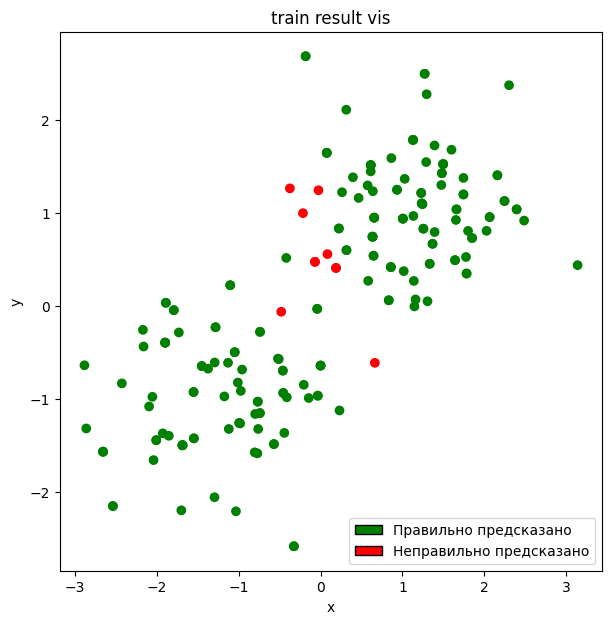

In [127]:
# Обучение
epoches = 10
epoch_steps = 15
lr = 1e-2

logreg = LogisticRegressionTorchAutograd(n_features=2)
optimizer = torch.optim.SGD(logreg.parameters(), lr=lr)

for epoch in range(epoches):
    logreg.train()
    losses = []
    for step in range(epoch_steps):
        optimizer.zero_grad()
        probs, loss = logreg(x, y)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
    print(f"{epoch=} | weight={logreg.w.weight.tolist()} | bias={logreg.w.bias.item():.4f} | mean_loss={sum(losses) / len(losses):.4f}")

# Визуализация
plt.figure(figsize=(7, 7))

logreg.eval()
with torch.no_grad():
    preds = logreg.predict(x).numpy()

colors = np.array(["r"] * len(preds))
colors[y.numpy().squeeze() == preds.squeeze()] = "g"
plt.scatter(x[:, 0], x[:, 1], c=colors)

legend_elements = [
    Patch(facecolor="green", edgecolor="black", label="Правильно предсказано"),
    Patch(facecolor="red", edgecolor="black", label="Неправильно предсказано")
]

plt.xlabel("x")
plt.ylabel("y")
plt.title("train result vis")
plt.legend(handles=legend_elements)
plt.show()

### ROC AUC

AUC = 0.5 → угадывает как монетка

AUC = 1.0 → всегда ставит правильному классу больше вероятность, чем неправильному

In [197]:
class Matches:

    def __init__(self, y_pred, y_target):
        self.tp = self.tn = self.fp = self.fn = 0
        for p, t in zip(y_pred, y_target):
            if p == t:
                if p == 0:
                    self.tn += 1
                else:
                    self.tp += 1
            else:
                if p == 0:
                    self.fn += 1
                else:
                    self.fp += 1


    @property
    def precision(self):
        # tp / (tp + fp) - точность
        # доля правильных отгадываний +класса из всех +срабатываний
        s = self.tp + self.fp
        if s == 0:
            return 0.
        
        return self.tp / s
    

    @property
    def recall(self):
        # tp / (tp + fn) - полнота, чувствительность к положительному классу
        # доля правильно отгаданных +классов из всех объектов +класса
        s = self.tp + self.fn
        if s == 0:
            return 0.
        
        return self.tp / s


    @property
    def fpr(self):
        s = self.fp + self.tn
        if s == 0:
            return 0.
        return self.fp / s


    @property
    def f1(self):
        pr, rc = self.precision, self.recall
        s = pr + rc 
        if s == 0:
            return 0.
        
        return 2 * pr * rc / s
        

def handmade_roc_curve(y_target, probs):
    roc_points = [(0, 0, 1.), (1, 1, 0.)]
    for threshold in torch.sort(torch.unique(probs))[0]:
        y_pred = torch.zeros_like(probs)
        y_pred[probs > threshold] = 1
        m = Matches(y_pred, y_target)
        roc_points.append((m.fpr, m.recall, threshold.item()))

    roc_points.sort(key=lambda x: (x[0], x[1]))
    roc_points = np.array(roc_points)
    
    return (roc_points[:, i] for i in range(3))


def handmade_roc_auc(tpr, fpr):
    return np.trapz(tpr, fpr)


def draw_roc_curve(fpr, tpr, thresholds):
    plt.figure(figsize=(8, 6))

    used_points = set()
    for i, (x_, y_, t_) in enumerate(zip(fpr, tpr, thresholds.round(2))):
        if (x_, y_) not in used_points:
            if i % 4 == 0:
                plt.scatter(x_, y_, s=5, c="b")
                plt.text(x_, y_, t_, fontsize=8, rotation=45, ha="center")
            used_points.add((x_, y_))
    plt.plot(fpr, tpr, label="linear regression autograd")
    plt.plot([0, 1], [0, 1])

    plt.xlabel("false positive rate")
    plt.ylabel("recall")
    plt.title("roc curve")
    plt.legend()
    plt.show()

C:\Users\user\AppData\Local\Temp\ipykernel_12728\1393919695.py:73: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(tpr, fpr)


Handmade ROC-AUC: 0.9968887996788438
Sklearn ROC-AUC: 0.9968887996788438


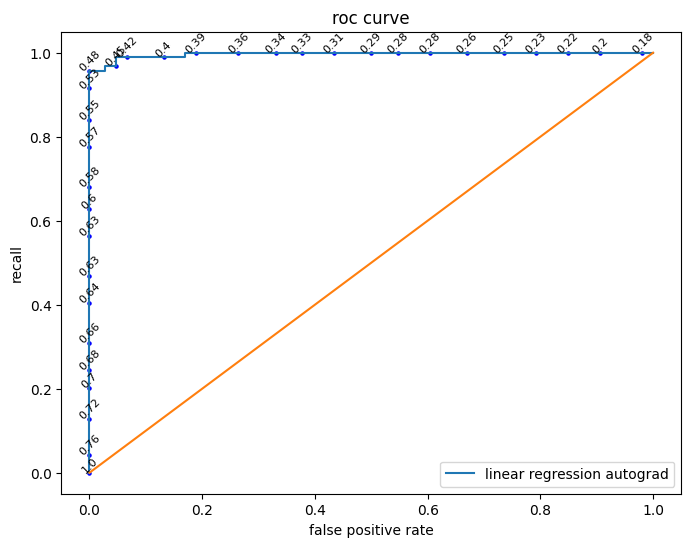

In [199]:
from sklearn.metrics import roc_auc_score


with torch.no_grad():
    probs = logreg(x)[0]

fpr, tpr, thresholds = handmade_roc_curve(y, probs)

print("Handmade ROC-AUC:", handmade_roc_auc(tpr, fpr))
print("Sklearn ROC-AUC:", roc_auc_score(y.numpy(), probs.numpy()))

draw_roc_curve(fpr, tpr, thresholds)

# Multiclass Logistic Regression

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_iris
from sklearn.metrics import classification_report


ds = load_iris()

x_tr, x_test, y_tr, y_test = train_test_split(ds["data"], ds["target"], test_size=0.2, random_state=42)

scaler = StandardScaler().fit(x_tr)
x_tr, x_test = scaler.transform(x_tr), scaler.transform(x_test)

x_tr_tensor, y_tr_tensor = torch.tensor(x_tr).float(), torch.tensor(y_tr).long()
x_test_tensor, y_test_tensor = torch.tensor(x_test).float(), torch.tensor(y_test).long()

### Мультиклассовая логистическая регрессия на torch без autograd

In [ ]:
class MultiClassLogisticRegressionTorch:

    def __init__(self, n_features: int, n_classes: int = 2, l2: float = 0.01):
        self.w = torch.randn((n_features, n_classes)) / n_features ** 0.5
        self.b = torch.zeros((n_classes, ))
        self.l2 = l2
        self.n_features = n_features
    
    
    def __call__(self, x: torch.Tensor):
        return x @ self.w + self.b
    

    def predict(self, x: torch.Tensor):
        return torch.argmax(self(x), dim=1)
        

    def fit(self, x: torch.Tensor, y: torch.Tensor, lr: float = 2e-3, max_steps: int = 100):
        n = len(x)

        losses = []
        for step in range(max_steps):

            # forward pass
            logits = self(x)
            max_logits = torch.max(logits, dim=1, keepdim=True).values
            preact = logits - max_logits  # чтобы не вычислять большие значения экспоненты (вероятности не изменятся)
            exp_preact = torch.exp(preact)
            sum_exps = torch.sum(exp_preact, dim=1, keepdim=True)  # (b, 1)
            probs = exp_preact / sum_exps  # soft-max
            correct_class_probs = probs[torch.arange(len(y)), y]
            cross_entropy_loss = -torch.mean(torch.log(correct_class_probs)) 
            loss = cross_entropy_loss + self.l2 * torch.sum(self.w ** 2)  # l2 норма весов

            # backward pass
            dloss_dw = 2 * self.l2 * self.w

            dloss_dprobs = torch.zeros_like(probs)
            dloss_dprobs[torch.arange(len(y)), y] = -1 / (correct_class_probs * n)

            dprobs_dexp_preact = 1 / sum_exps  # (b, 1)
            dloss_dexp_preact = dprobs_dexp_preact * dloss_dprobs  # (b, c)

            dprobs_dsum_exps = -exp_preact / sum_exps ** 2
            dloss_dsum_exps = torch.sum(dprobs_dsum_exps * dloss_dprobs, dim=1, keepdim=True)  # (b, 1)

            dsum_exps_dexp_preact = exp_preact
            dloss_dexp_preact += dsum_exps_dexp_preact * dloss_dsum_exps
            
            dexp_preact_dpreact = exp_preact
            dloss_dpreact = dexp_preact_dpreact * dloss_dexp_preact

            dpreact_dlogits = torch.ones_like(logits)
            dloss_dlogits = dpreact_dlogits * dloss_dpreact

            dpreact_dmax_logits = -1
            dloss_dmax_logits = dpreact_dmax_logits * dloss_dpreact

            dmax_logits_dlogits = torch.zeros_like(logits)
            dmax_logits_dlogits[logits == max_logits] = 1
            dloss_dlogits += dmax_logits_dlogits * dloss_dmax_logits

            dlogits_dw = x.T
            dloss_dw += dlogits_dw @ dloss_dlogits
            dloss_db = torch.sum(dloss_dlogits, dim=0)

            self.w -= dloss_dw * lr
            self.b -= dloss_db * lr

            losses.append(loss.item())

        return losses

In [99]:
logreg = MultiClassLogisticRegressionTorch(n_features=x_tr.shape[1], n_classes=len(np.unique(y_tr)))
for epoch in range(10):
    losses = logreg.fit(x_tr_tensor, y_tr_tensor, max_steps=20, lr=4.5e-2)
    print(f"{epoch=} | mean_loss={sum(losses) / len(losses):.4f}")

epoch=0 | mean_loss=1.1169
epoch=1 | mean_loss=0.8937
epoch=2 | mean_loss=0.7724
epoch=3 | mean_loss=0.7073
epoch=4 | mean_loss=0.6724
epoch=5 | mean_loss=0.6565
epoch=6 | mean_loss=0.6494
epoch=7 | mean_loss=0.6461
epoch=8 | mean_loss=0.6452
epoch=9 | mean_loss=0.6450


### Мультиклассовая логистическая регрессия на torch c autograd

In [103]:
class MultiClassLogisticRegressionTorchAutograd(nn.Module):

    def __init__(self, n_features: int, n_classes: int = 2, l2: float = 0.01):
        super().__init__()

        self.w = nn.Linear(in_features=n_features, out_features=n_classes, bias=True)
        self.l2 = l2
    
    
    def forward(self, x: torch.Tensor, y: torch.Tensor = None):
        logits = self.w(x)

        loss = None
        if y is not None:
            loss = nn.CrossEntropyLoss()(logits, y) + self.l2 * torch.sum(self.w.weight ** 2)

        return logits, loss
    

    def predict(self, x: torch.Tensor):
        logits, _ = self(x)
        return torch.argmax(logits, dim=1)

In [110]:
epoches = 10
epoch_steps = 20
lr = 3.5e-2

logreg = MultiClassLogisticRegressionTorchAutograd(
    n_features=x_tr.shape[1], 
    n_classes=len(np.unique(y_tr)),
)
optimizer = torch.optim.SGD(logreg.parameters(), lr=lr)

for epoch in range(epoches):
    logreg.train()
    losses = []
    for step in range(epoch_steps):
        optimizer.zero_grad()
        logits, loss = logreg(x_tr_tensor, y_tr_tensor)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
    print(f"{epoch=} | mean_loss={sum(losses) / len(losses):.4f}")

epoch=0 | mean_loss=1.0886
epoch=1 | mean_loss=0.7022
epoch=2 | mean_loss=0.5795
epoch=3 | mean_loss=0.5233
epoch=4 | mean_loss=0.4906
epoch=5 | mean_loss=0.4686
epoch=6 | mean_loss=0.4524
epoch=7 | mean_loss=0.4398
epoch=8 | mean_loss=0.4296
epoch=9 | mean_loss=0.4211


### Сравнение с scklearn на iris dataset

В sklearn параметр C — это обратная сила регуляризации. То есть чем больше C, тем слабее штраф (модель свободнее). Чем меньше C, тем сильнее мы ограничиваем веса.

In [111]:
logreg.eval()
with torch.no_grad():
    print("Train report:\n", classification_report(y_tr, logreg.predict(x_tr_tensor).numpy()))
    print("Test report:\n", classification_report(y_test, logreg.predict(x_test_tensor).numpy()))

Train report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        40
           1       0.90      0.68      0.78        41
           2       0.73      0.92      0.82        39

    accuracy                           0.87       120
   macro avg       0.88      0.87      0.87       120
weighted avg       0.88      0.87      0.86       120

Test report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      0.89      0.94         9
           2       0.92      1.00      0.96        11

    accuracy                           0.97        30
   macro avg       0.97      0.96      0.97        30
weighted avg       0.97      0.97      0.97        30



In [25]:
from sklearn.linear_model import LogisticRegression


m_sklearn = LogisticRegression(penalty="l2", C=100, solver="lbfgs")
m_sklearn.fit(x_tr, y_tr)

preds_tr = m_sklearn.predict(x_tr)
preds_test = m_sklearn.predict(x_test)

print("Train report:\n", classification_report(y_tr, preds_tr))
print("Test report:\n", classification_report(y_test, preds_test))

Train report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        40
           1       0.98      0.98      0.98        41
           2       0.97      0.97      0.97        39

    accuracy                           0.98       120
   macro avg       0.98      0.98      0.98       120
weighted avg       0.98      0.98      0.98       120

Test report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00        11

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



### Cross Validation, подбор гиперпараметров

! Кросс-валидация даёт оценку качества гиперпараметров на разных разбиениях данных, помогая выбрать обобщающие параметры, а не те, что переобучились на одной валидации.

! Если f1_score высокий, а accuracy — низкий: если accuracy низкий, значит большое количество ошибок, а f1 высокий — значит по одному классу модель работает хорошо. Классовый дисбаланс и доминирующее предсказание.

In [51]:
from time import time
from itertools import product
import warnings

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

warnings.simplefilter("ignore")


class CrossValidation:

    def __init__(self):
        self.best_params = {}
        self.best_metric = 0
        self.best_time = 1e10
        self.history = []


    @staticmethod
    def hyperparameter_combs(hyperparameters: dict[str, list]):
        keys = list(hyperparameters.keys())
        values = list(hyperparameters.values())
        return [dict(zip(keys, v)) for v in product(*values)]


    @staticmethod
    def make_folds(x: np.array, y: np.array, k_folds: int = 2):
        l_fold = len(x) // k_folds
        for i in range(k_folds):
            st, en = i * l_fold, (i + 1) * l_fold
            train_x = np.vstack((x[:st], x[en:]))
            test_x = x[st : en]
            train_y = np.hstack((y[:st], y[en:]))
            test_y = y[st : en]
            yield train_x, test_x, train_y, test_y


    def fit(
        self,
        model_class, 
        fit_func_name: str,
        predict_func_name: str,
        x_data: np.array,
        y_data: np.array,
        hyperparameters: dict, 
        metric: callable,
        metric_params: dict,
        k_folds: int = 10, 
    ):
        metric_name = metric.__name__.upper()

        for params in CrossValidation.hyperparameter_combs(hyperparameters):
            metrics = []

            st = time()
            for train_x, test_x, train_y, test_y in CrossValidation.make_folds(x_data, y_data, k_folds=k_folds):
                model = model_class(**params)
                getattr(model, fit_func_name)(train_x, train_y)
                preds = getattr(model, predict_func_name)(test_x)
                metrics.append(metric(test_y, preds, **metric_params))
            en = time()

            dur = en - st
            mean_metric = sum(metrics) / k_folds
            if (mean_metric > self.best_metric) or (mean_metric == self.best_metric and dur < self.best_time):
                self.best_metric = mean_metric
                self.best_time = dur
                self.best_params = params
            
            print(f"PARAMS: {params} | MEAN {metric_name}: {mean_metric:.4f} | TIME: {dur:.4f}")

            self.history.append({"params": params, "metric": mean_metric, "time": dur})


hyperparameters = {
    "penalty": ["l2"], 
    "random_state": [42],
    "solver": ["newton-cholesky", "lbfgs"],
    "C": [0.125, 0.5, 1, 2, 8], 
    "max_iter": [50, 100, 200], 
}


cv = CrossValidation()
cv.fit(
    model_class=LogisticRegression,
    fit_func_name="fit",
    predict_func_name="predict",
    x_data=ds["data"],
    y_data=ds["target"],
    hyperparameters=hyperparameters,
    metric=f1_score,
    metric_params={"average": "macro"},
    k_folds=10,
)

PARAMS: {'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cholesky', 'C': 0.125, 'max_iter': 50} | MEAN F1_SCORE: 0.6827 | TIME: 0.0530
PARAMS: {'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cholesky', 'C': 0.125, 'max_iter': 100} | MEAN F1_SCORE: 0.6827 | TIME: 0.0410
PARAMS: {'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cholesky', 'C': 0.125, 'max_iter': 200} | MEAN F1_SCORE: 0.6827 | TIME: 0.0400
PARAMS: {'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cholesky', 'C': 0.5, 'max_iter': 50} | MEAN F1_SCORE: 0.7339 | TIME: 0.0420
PARAMS: {'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cholesky', 'C': 0.5, 'max_iter': 100} | MEAN F1_SCORE: 0.7339 | TIME: 0.0420
PARAMS: {'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cholesky', 'C': 0.5, 'max_iter': 200} | MEAN F1_SCORE: 0.7339 | TIME: 0.0430
PARAMS: {'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cholesky', 'C': 1, 'max_iter': 50} | MEAN F1_SCORE: 0.7358 | TIME: 0.0460
PARAMS: {'pe

# Регуляризация

! Регуляризация — метод добавления некоторых дополнительных ограничений к условию с целью решить некорректно поставленную задачу или предотвратить переобучение. Чаще всего эта информация имеет вид штрафа за сложность модели. 

! Если val loss начинает расти, а train loss падает — это типичный признак переобучения. Можно:

-применить early stopping,

-усилить регуляризацию,

-уменьшить модель (в случае нейросетей).

! ElasticNet регуляризация - l1 + l2

L1 даёт разреженность, L2 — стабильность.

ElasticNet полезен, когда признаки сильно коррелированы — чистый L1 будет случайно выбирать между ними, а ElasticNet усредняет.

```
loss = loss + lam1 * self.w.weight.abs().sum() + lam2 * (self.w.weight ** 2).sum()
```

! Как регуляризация помогает бороться с переобучением? Некоторые веса в процессе обучения могут стать очень большими, это происходит, когда модель начинает подбирать идеальные коэффициенты под тренировочные данные. При регуляризации накладывается штраф на большие веса, что мешает модели сойтись к идеальному решению на train. Регуляризация делает модель более устойчивой к шуму и снижает её сложность.

! L1 порождает разреженные решения, эффективно зануляя некоторые веса. Особенно актуально при большом числе признаков.

L2-штраф даёт производную линейную по весу: ∂/∂w_i [w_i²] = 2w_i, и именно это тянет веса к нулю, но не обнуляет их полностью. В отличие от L1, у которого производная кусочная: ±1 или 0.

Геометрически: ограничения L1 создают “ромб” (в 2D), что делает нули вероятными точками касания с изолиниями функции потерь → разреженность.

Аналитически: производная L1 — кусочная (±1 или 0), что позволяет «сбросить» вес полностью. L2 же тянет веса к нулю плавно, но редко обнуляет.

### Label smoothing

In [56]:
# Штраф за уверенность модели
num_classes = 4
batch_size = 2
true_labels = torch.tensor([2, 1])  # True class indices
predictions = torch.tensor([[0.1, 0.2, 0.7, 0.0], [0.2, 0.7, 0.1, 0.0]]) 

# Label smoothing function
def label_smoothed_nll_loss(lprobs, target, eps=0.1):
    lprobs = lprobs.view(-1, lprobs.size(-1))
    target = target.view(-1, 1)
    nll_loss = -lprobs.gather(dim=-1, index=target)  # Выбрали лог. вероятности правильного класса по каждой строчке
    smooth_loss = -lprobs.mean(dim=-1)  # Средняя лог. вероятность по каждой строчке
                                        # Большая уверенность модели в своем предсказании -> у других классов меньше вероятность -> 
                                        # У других классов большое значение лог. вероятности -> большой штраф
    loss = (1.0 - eps) * nll_loss + eps * smooth_loss
    return loss.sum()

log_probs = F.log_softmax(predictions, dim=-1)
loss = label_smoothed_nll_loss(log_probs, true_labels, eps=0.1)

loss.item()

4.081147193908691